In [19]:
import pymorphy2
import re
import os
import string
import glob
from tqdm import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
morph = pymorphy2.MorphAnalyzer()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.utils as utils
from sklearn.metrics import accuracy_score, pairwise_distances
from sklearn.tree import DecisionTreeClassifier

In [3]:
os.chdir(r"C:\Users\etrib\Documents\Diploma\Diploma\factRuEval-2016-practice-master\train_test")
data_list = os.listdir(r"C:\Users\etrib\Documents\Diploma\Diploma\factRuEval-2016-practice-master\train_test") 
docs = list(filter(lambda x: x.endswith('.txt'), data_list))
docs.sort()
docs.sort(key = lambda x: len(x))

In [4]:
docs1 =[]
for doc in docs:
    docs1.append(open(doc, encoding='utf-8').read())

In [5]:
def word(w, pos):
    feat = [0 for i in range(13)]
    if w == "qwert":
        return tuple(feat)
    if not(w.isdigit()):
        if len(w) != 0:
            if w[0].isupper():
                feat[0] = 1
        t = morph.parse(w)
        if t[0].tag.POS == "NOUN":
            feat[1] = 1
        if t[0].tag.POS == "ADJF":
            feat[2] = 1
        if t[0].tag.case == "nomn":
            feat[3] = 1
        if t[0].tag.case == "gent":
            feat[4] = 1
        if t[0].tag.case == "datv":
            feat[5] = 1
        if t[0].tag.case == "accs":
            feat[6] = 1
        if t[0].tag.case == "ablt":
            feat[7] = 1
        if t[0].tag.case == "loct":
            feat[8] = 1
        if t[0].tag.gender == "masc":
            feat[9] = 1
        if t[0].tag.number == "plur":
            feat[10] = 1
        feat[11] = 1 if pos == 0 else 0
        feat[12] = int(w.isupper())
    return tuple(feat)

In [6]:
list_of_res = []
stop_words = stopwords.words('russian')
for d in tqdm(docs1):
    d = d.split()
    c = []
    flag = 0
    for j, i in enumerate(d):
        if morph.parse(i)[0].normal_form in stop_words:
            i = "qwert"
        if flag:
            c.append(word(i.rstrip(string.punctuation), 0))
        else:
            c.append(word(i.rstrip(string.punctuation), 1))
        if '.' in i:
            flag = 1
        else:
            flag = 0
    list_of_res.append(c)

100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [03:00<00:00,  1.41it/s]


In [7]:
docs = list(filter(lambda x: x.endswith('.spans'), data_list))
docs.sort()
docs.sort(key = lambda x: len(x))
j = 0
#for i in docs:
#    print(j, " ", i)
#    j +=1

In [8]:
list_of_df = []
i = 0
for my_str in docs:
#    print(i)
    if os.stat(my_str).st_size != 0:
        d = pd.read_csv(my_str, sep = ' ', encoding='utf-8')
        list_of_df.append(d)
    i+=1

In [9]:
list_pos = []
for i in list_of_df:
    temp = []
    p = i
    k = p[(p.type_of_span == 'surname')  | (p.type_of_span == 'name')]
    for i in range(k.shape[0]):
        temp.append(k.iloc[[i], [2]].values[0][0])
    list_pos.append(temp)

In [10]:
docs = list(filter(lambda x: x.endswith('.txt'), data_list))
docs.sort()
docs.sort(key = lambda x: len(x))
target_list = []
list_of_res1 = []
crot = 0
for d in docs[:len(docs)-1:]:
    temp = []
    count = 0
    f = open(d, 'r', encoding = 'utf-8')
    p = f.read().split('\n')
#    print(crot, " ",len(p))
    for r in p:
        if len(r) == 0:
            count += 1
        for c in r.split():
            if count in list_pos[crot]:
                temp.append(1)
                list_of_res1.append(c)
            else:
                temp.append(0)                
            count += len(c)+1
    crot += 1
    target_list.append(temp)

In [11]:
print(len(target_list))
print(len(list_of_res))

253
254


In [12]:
list_of_res = list_of_res[:-1]

In [13]:
for i in range(len(target_list)):
    assert(len(target_list[i]) == len(list_of_res[i]))

In [98]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import  fetch_20newsgroups

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric
from sklearn.metrics import accuracy_score, pairwise_distances

from scipy.spatial.distance import cdist

In [99]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm = 'brute', metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        self.minlen = len(np.unique(y))
        self.Y_train = y
        if self.algorithm == 'brute':
            self.X_train = X
        elif self.algorithm == 'kd_tree':
            self.X_tree = KDTree(X)    
        
    def predict(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X_train, metric = self.metric)
            indexes = np.argpartition(distances, self.n_neighbors, axis = 1)[:,:self.n_neighbors]
            return np.apply_along_axis(np.bincount,1,self.Y_train[indexes], minlength = self.minlen).argmax(axis=1)
        elif self.algorithm == 'kd_tree':
            t = self.X_tree.query(X, k = self.n_neighbors)
            return np.apply_along_axis(np.bincount, 1, self.Y_train[t[1]], minlength = self.minlen).argmax(axis = 1)
        
    def score(self,X,y):
        return accuracy_score(y,self.predict(X))

In [100]:

import sklearn.utils as utils
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        X_temp, y_temp = utils.shuffle(X, y)
    else:
        X_temp, y_temp = X, y
    for i in np.arange(0, len(y), batch_size):
        X_batch = X_temp[i:i+batch_size]
        y_batch = y_temp[i:i+batch_size]
        yield (X_batch, y_batch)

from sklearn.base import BaseEstimator, ClassifierMixin
from math import exp, log2, log

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    
    try:
        sigm_value_x = 1/(1 + exp(-x))
        return sigm_value_x
    except OverflowError:
        return 1e-50

def mylog2(x):
    if x == 0.0:
        return -1.3131231e+70
    return log2(x)

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C = 1, alpha = 0.01, max_epoch = 10, model_type = 'lin_reg',
                 batch_size = 1, border = 0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тип модели, lin_reg или log_reg
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.loss_values = []
        self.type = model_type
        self.batch_size = batch_size
        self.border = border
        if model_type == 'lin_reg':
            self.C1 = 1
        else:
            self.C1 = 1 / (2 * log(2))
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        
        X = np.array(X_batch)
        add = np.array([1] * (X.shape[0]))
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        y = np.array(y_batch)
        
        w = np.array(self.weights)
        loss = X * w
        loss = loss.sum(axis = 1).ravel()
        
        if self.type == 'lin_reg':
            loss = (loss - y) ** 2
            loss = loss.sum()
        elif self.type == 'log_reg':
            loss = np.array(list(map(sigmoid, loss)))
            ones = loss[np.where(y == 1)]
            ones = np.array(list(map(mylog2, ones)))
            zeros = -loss[np.where(y == 0)]
            zeros += 1
            zeros = np.array(list(map(mylog2, zeros)))
            loss = -zeros.sum() - ones.sum()
        
        loss /= np.size(y)
        
        reg = w ** 2
        reg = reg.sum() / self.C
        
        return loss + reg
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        X = np.array(X_batch)
        ones = np.array([1] * (X.shape[0])).reshape(-1, 1)
        X = np.hstack((ones, X))
        
        y = np.array(y_batch).reshape(1, -1)
        w = np.array(self.weights).reshape(1, -1)
        a = X * w
        a = a.sum(axis = 1).ravel()
        
        if self.type == 'log_reg':
            a = np.array(list(map(sigmoid, a)))
            
        a = a - y
        a = a.reshape(-1, 1)
        loss_grad = X * a
        loss_grad = loss_grad.mean(axis = 0) * self.C1
        reg = w / self.C
        
        return 2 * (loss_grad + reg)[0]
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализировать случайно веса
        X = np.array(X)
        y = np.array(y)
        np.random.seed(20)
        self.weights = np.random.randint(1, 10, size = X.shape[1] + 1)
        self.weights = self.weights.astype(float)
        for i in range(0, self.max_epoch):
            new_gen = self.batch_generator(X, y, shuffle = True, batch_size = self.batch_size)
            for batch in new_gen:
                X_batch, y_batch = batch[0], batch[1]
                loss = self.calc_loss(X_batch, y_batch)
                self.loss_values.append(loss)
                
                grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(grad)
            self.alpha /= 2
                
        self.loss_values.append(self.calc_loss(X, y))
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.array(X)
        add = np.array([1] * X.shape[0])
        add = add.reshape(-1, 1)
        X = np.hstack((add, X))
        
        w = np.array(self.weights)
        y_pred = X * w
        y_pred = y_pred.sum(axis = 1).ravel()
        if self.type == 'log_reg':
            y_pred = np.array(list(map(sigmoid, y_pred)))
            y_pred = (y_pred >= self.border).astype(int)
        return y_pred

In [101]:

import sklearn.utils as utils
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    
    if shuffle:
        X_temp, y_temp = utils.shuffle(X, y)
    else:
        X_temp, y_temp = X, y
    for i in np.arange(0, len(y), batch_size):
        X_batch = X_temp[i:i+batch_size]
        y_batch = y_temp[i:i+batch_size]
        yield (X_batch, y_batch)

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value = 1/(1+np.exp(-x))

    return sigm_value

from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg',batch_size=10,threshold = 0.5):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.batch_size = batch_size
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.threshold = threshold
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        N = len(y)
        if(self.model_type == 'lin_reg'):            
            loss = 1/N*(y_batch - np.dot(X_batch, self.weights)) ** 2         
        if(self.model_type == 'log_reg'):            
            p = sigmoid(np.dot(X_batch, self.weights))
            loss = -1/N*(y_batch * np.log(p) + (1-y_batch) * np.log(1-p))
        loss += np.sum(self.weights ** 2)/ self.C
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        N=len(y) 
        Xw = np.dot(X_batch, self.weights)
        if(self.model_type == 'lin_reg'):
            lossgr = 2/N*np.dot(Xw - y_batch, X_batch)
        if(self.model_type == 'log_reg'):
            Xw = sigmoid(Xw)
            lossgr = 1/N*np.dot(Xw - y_batch, X_batch)
        lossgr += 2*self.weights/self.C
        return lossgr
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights -= self.alpha*new_grad
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        # Нужно инициализровать случайно веса
        self.weights = np.random.uniform(0,2,X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for num, batch in enumerate(new_epoch_generator):
                X_batch, y_batch = batch
                grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(grad)
                # Подумайте в каком месте стоит посчитать ошибку для отладки модели
                # До градиентного шага или после
                loss = self.calc_loss(X_batch, y_batch)          
                self.errors_log['iter'].append(num)
                self.errors_log['loss'].append(loss)     
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        if(self.model_type == 'lin_reg'):
            y_hat = np.dot(X, self.weights)
            y_hat=np.array(list(map(int, np.dot(X, self.weights) > self.threshold)))
        if(self.model_type == 'log_reg'):
            temp = sigmoid(np.dot(X, self.weights))
            y_hat=np.array(list(map(int, temp > self.threshold)))
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return y_hat

In [36]:
knn, sgd, tree = KNeighborsClassifier(n_neighbors = 8), SGDClassifier(), DecisionTreeClassifier(max_depth = 8)

In [15]:
X_new = []
for i in list_of_res:
    for x in i:
        X_new.append(x)
y_new = []
for i in target_list:
    for x in i:
        y_new.append(x)

In [16]:
X, y = np.array(X_new), np.array(y_new)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1,  random_state=0)
X_train.shape, y_train.shape

((66422, 13), (66422,))

8


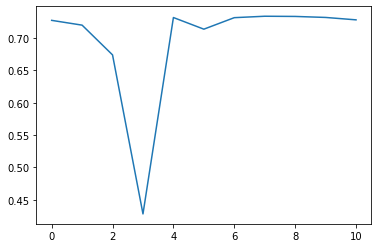

In [34]:
temp = []
for i in range(1, 12):
    k = KNeighborsClassifier(n_neighbors = i)
    k.fit(X_train, y_train)
    temp.append(f1_score(k.predict(X_test), y_test))
plt.plot(temp)
best_param = np.argmax(temp)
print(best_param+1)

C:\Users\etrib\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


7


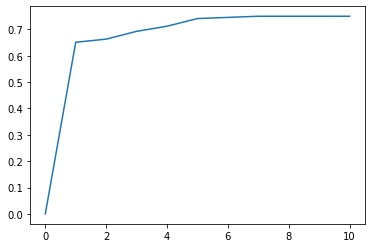

In [24]:
temp = []
for i in range(1, 12):
    t = DecisionTreeClassifier(max_depth = i)
    t.fit(X_train, y_train)
    temp.append(f1_score(t.predict(X_test), y_test))
plt.plot(temp)
best_param = np.argmax(temp)
print(best_param)

In [39]:
sgd.fit(X_train, y_train)
knn.fit(X_train, y_train)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [277]:
#old result
print(f1_score(sgd.predict(X_test), y_test))
print(f1_score(knn.predict(X_test), y_test))
print(f1_score(tree.predict(X_test), y_test))

0.6912751677852349
0.6959459459459459
0.7371601208459213


In [40]:
#new_result
print(f1_score(sgd.predict(X_test), y_test))
print(f1_score(knn.predict(X_test), y_test))
print(f1_score(tree.predict(X_test), y_test))

0.7083969465648855
0.7336244541484715
0.7500000000000001


In [224]:
features = ['Первая буква заглавная','Сущ.','Прилаг.','Глагол','Союз','Именит.','Род.','Дат.','Винит.','Твор.','Предлож.','Муж.','Жен.','Первое слово в предложении','Все буквы заглавные','Одушевленный']
p = list(zip(features,tree.feature_importances_))
p.sort(key = lambda x: x[1], reverse = True)
p

[('Первая буква заглавная', 0.4706088574386281),
 ('Сущ.', 0.02834114415656145),
 ('Прилаг.', 0.010407587322207909),
 ('Глагол', 0.001668846632141924),
 ('Союз', 0.0008870097911468075),
 ('Именит.', 0.023164670476140417),
 ('Род.', 0.008215572812489186),
 ('Дат.', 0.007215233460930916),
 ('Винит.', 0.006487551955772331),
 ('Твор.', 0.004374433180325929),
 ('Предлож.', 0.046235679951058185),
 ('Муж.', 0.24120390900216543),
 ('Жен.', 0.018138022725477005),
 ('Первое слово в предложении', 0.07308089442971791),
 ('Все буквы заглавные', 0.05801479198518237),
 ('Одушевленный', 0.0019557946800542216)]

In [41]:
def func(my_str):
    temp = []
    new_str = []
    for j, i in enumerate(my_str.split()):
        if i.rstrip(string.punctuation) in stop_words:
            i = "qwert"
        new_str.append(word(i.rstrip(string.punctuation), j))
    #    print(word(i.rstrip(string.punctuation), j))
    p = sgd.predict(new_str)
    new_str = ""
    for j, i in enumerate(my_str.split()):
        if p[j] == 1:
            i = "[ PER " + i + " ]"
        new_str += " " + i
    print(new_str)

In [42]:
examp = []
examp.append("Однажды весною, в час небывало жаркого заката, в Москве, на Патриарших прудах, появились два гражданина. Первый был не кто иной, как Михаил Александрович Берлиоз, председатель правления одной из крупнейших московских литературных ассоциаций, сокращенно именуемой МАССОЛИТ.")
examp.append("Президент РФ Владимир Путин выступит с заявлением на встрече с губернаторами во вторник, 28 апреля, заявил губернатор Вологодской области Олег Кувшинников. Ранее обращение президента анонсировал пресс-секретарь главы государства Дмитрий Песков.")
examp.append("В разное время обладателями «Хрустального компаса» становились Фёдор Конюхов и Фредерик Паулсен, National geographic society и МГУ им. Ломоносова, Северный флот и подразделения РАН и др. Премия проводится под эгидой Русского географического общества и ПАО «Газпром».")
examp.append("Пантеле́й Деми́дович Пя́нда роидлся в 1587 году. Им была открыта река Cысола в 1623.")
examp.append("18 августа 2008 года на пекинской Олимпиаде Елена Исинбаева установила мировой рекорд — 5,05 м.")

In [48]:
for i in range(5):
    func(examp[i])
    print("\n")

 Однажды весною, в час небывало жаркого заката, в Москве, на Патриарших прудах, появились два гражданина. Первый был не кто иной, как [ PER Михаил ] [ PER Александрович ] [ PER Берлиоз, ] председатель правления одной из крупнейших московских литературных ассоциаций, сокращенно именуемой МАССОЛИТ.


 Президент РФ [ PER Владимир ] [ PER Путин ] выступит с заявлением на встрече с губернаторами во вторник, 28 апреля, заявил губернатор Вологодской области [ PER Олег ] [ PER Кувшинников. ] Ранее обращение президента анонсировал пресс-секретарь главы государства [ PER Дмитрий ] [ PER Песков. ]


 В разное время обладателями «Хрустального компаса» становились [ PER Фёдор ] [ PER Конюхов ] и [ PER Фредерик ] [ PER Паулсен, ] National geographic society и МГУ им. [ PER Ломоносова, ] Северный флот и подразделения РАН и др. Премия проводится под эгидой Русского географического общества и ПАО «Газпром».


 Пантеле́й [ PER Деми́дович ] [ PER Пя́нда ] роидлся в 1587 году. Им была открыта река [ PER C